In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import itertools
import joblib
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,RobustScaler,Normalizer,MaxAbsScaler
from sklearn.model_selection import train_test_split
from airbnbCABATransformer import AirbnbCABATransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from hyperopt import hp, Trials, tpe
from HPOpt import HPOpt

In [2]:
#Cargamos el dataset limpio 
data = pd.read_csv('data/listings.csv')
data1 = pd.read_csv('data/listings_1.csv')
data2 = pd.read_csv('data/listings_2.csv')
data3 = pd.read_csv('data/listings_3.csv')
data = pd.concat([data, data1,data2,data3])
#data = data.drop_duplicates(subset=data.columns.difference(['price']))
data = data.drop_duplicates()
data = data.reset_index()
data = data.drop(["index"],axis=1)

In [3]:
dataclean = AirbnbCABATransformer().transform(data)
dataclean.head()

This pattern has match groups. To actually get the groups, use str.extract.


,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,...,Villa Santa Rita,Villa Soldati,Villa Urquiza,Apartment,House,Entire home/apt,Private room,Shared room,bathroomtype_private,bathroomtype_shared
0,0.0,1,2,1,1,9823,3,1125,30,4.77,...,0,0,0,1,0,1,0,0,1,0
1,1.0,1,2,1,1,5687,2,730,24,4.63,...,0,0,0,1,0,1,0,0,1,0
2,0.0,1,2,1,1,3728,7,1125,98,4.77,...,0,0,0,1,0,1,0,0,1,0
3,1.0,1,4,2,1,6514,14,1125,10,4.67,...,0,0,0,1,0,1,0,0,1,0
4,1.0,0,2,1,1,3584,5,730,29,4.79,...,0,0,0,1,0,1,0,0,1,0


In [4]:
dataclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47883 entries, 0 to 49826
Data columns (total 74 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       47883 non-null  float64
 1   host_identity_verified  47883 non-null  int32  
 2   accommodates            47883 non-null  int32  
 3   bathrooms               47883 non-null  int32  
 4   bedrooms                47883 non-null  int32  
 5   price                   47883 non-null  int64  
 6   minimum_nights          47883 non-null  int64  
 7   maximum_nights          47883 non-null  int32  
 8   number_of_reviews       47883 non-null  int64  
 9   review_scores_rating    47883 non-null  float32
 10  air_conditioning        47883 non-null  int32  
 11  pool                    47883 non-null  int32  
 12  parking                 47883 non-null  int32  
 13  tv                      47883 non-null  int32  
 14  internet                47883 non-null

In [5]:
#Genero mi variable X
X=dataclean.drop(['price'],axis=1)

#Genero la variable y
y = dataclean['price']

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=41)

---
### Funciones extras

In [6]:
def getscores(model,X_test,y_test,X_train,y_train,model_name):
    y_pred_test = model.predict(X_test)
    
    mse_test = np.round(mean_squared_error(y_test, y_pred_test),5)
    rmse_test = np.round(np.sqrt(mse_test),5)
    mae_test = np.round(mean_absolute_error(y_test, y_pred_test),5)
    r2_test =  np.round(r2_score(y_test, y_pred_test),5)
    
    y_pred_train = model.predict(X_train)

    mse_train = np.round(mean_squared_error(y_train, y_pred_train),5)
    rmse_train = np.round(np.sqrt(mse_train),5)
    mae_train = np.round(mean_absolute_error(y_train, y_pred_train),5)
    r2_train =  np.round(r2_score(y_train, y_pred_train),5)
    
    data = [mse_test,rmse_test,mae_test,r2_test, mse_train,rmse_train,mae_train,r2_train]
    
    return {model_name:data}
    
def plot_train_test(y_test, y_pred_test, y_train, y_pred_train, model_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

    axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
    axes[0].plot([i for i in range(len(y_test))],y_pred_test, 'bo', label="Predicted "+model_name+" values")
    axes[0].legend()

    axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
    axes[1].plot([i for i in range(len(y_train))],y_pred_train, 'bo', label="Predicted "+model_name+" values")
    axes[1].legend()

    fig.text(0.5, 0.09, 'Item', ha='center')
    fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
    plt.show()

---
## Algoritmos
### Árboles

In [7]:
# Random Forest
rndfo_reg_params = {
    'bootstrap':         hp.choice('bootstrap', ["True", "False"]),
    'max_depth':         hp.choice("max_depth", np.arange(1, 11, 1, dtype=int)),
    'max_features':      hp.choice('max_features', ['auto', 'sqrt','log2']),
    'min_samples_leaf':  hp.choice('min_samples_leaf', [0.1,1,2,4]),
    'min_samples_split': hp.choice('min_samples_split', [0.1,0.5,0.8,0.9,2,4,6]),
    'n_estimators':      hp.randint('n_estimators', 100, 1000),
    'random_state' : 50,
    'verbose': False,
    'n_jobs' :-1,
}

rndfo_para = dict()
rndfo_para['reg_params'] = rndfo_reg_params
rndfo_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.3,0.5, 0.8, 0.1]),
    'subsample':        hp.uniform('subsample', 0, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
    'eval_metric': 'rmse',
}
xgb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    [0.001,0.01,0.1,0.2,0.3,0.5,1]),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 10, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', [0.1,0.3,0.5, 0.8, 0.1]),
    'subsample':        hp.uniform('subsample', 0.1, 1),
    'n_estimators':     hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
    'random_state':     50,
}

lgb_fit_params = {
    'eval_metric':      'l2',
    'early_stopping_rounds': 10,
    'verbose': False,
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# CatBoost parameters
ctb_reg_params = {
    'random_state':   50,
    'learning_rate':  hp.uniform('learning_rate', 0.1, 0.5),
    'iterations':     hp.randint('iterations',100,1000),
    'l2_leaf_reg':    hp.randint('l2_leaf_reg',1,10),
    'depth':          hp.randint('depth',1,10),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli']),
    'eval_metric':    'RMSE',
}

ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False,
}

ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [8]:
obj = HPOpt(X_train, X_test, y_train, y_test)

trials = [Trials(),Trials(),Trials(),Trials()]

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=trials[0], algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=trials[1], algo=tpe.suggest, max_evals=100)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=trials[2], algo=tpe.suggest, max_evals=100)
rndfor_opt = obj.process(fn_name='rndfor_reg', space=rndfo_para, trials=trials[3], algo=tpe.suggest, max_evals=100)

  1%|▍                                                | 1/100 [00:00<00:35,  2.82trial/s, best loss: 3706.830188819999]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  2%|▉                                                | 2/100 [00:19<19:05, 11.68s/trial, best loss: 3706.830188819999]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  3%|█▍                                              | 3/100 [00:22<11:51,  7.34s/trial, best loss: 3259.4089903526115]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  4%|█▉                                              | 4/100 [00:25<09:29,  5.93s/trial, best loss: 3259.4089903526115]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  5%|██▍                                             | 5/100 [00:26<06:34,  4.16s/trial, best loss: 3259.4089903526115]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  6%|██▉                                             | 6/100 [00:30<06:14,  3.98s/trial, best loss: 3259.4089903526115]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  7%|███▎                                            | 7/100 [00:31<04:37,  2.98s/trial, best loss: 3259.4089903526115]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  8%|███▊                                            | 8/100 [00:32<03:32,  2.31s/trial, best loss: 3259.4089903526115]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  9%|████▎                                           | 9/100 [00:34<03:23,  2.23s/trial, best loss: 3259.4089903526115]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 10%|████▋                                          | 10/100 [00:45<07:21,  4.91s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 11%|█████▏                                         | 11/100 [00:47<05:54,  3.98s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 12%|█████▋                                         | 12/100 [00:47<04:10,  2.85s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 13%|██████                                         | 13/100 [00:50<04:09,  2.87s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 14%|██████▌                                        | 14/100 [00:55<05:01,  3.50s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 15%|███████                                        | 15/100 [00:55<03:35,  2.53s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 16%|███████▌                                       | 16/100 [00:56<02:51,  2.04s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 17%|███████▉                                       | 17/100 [01:03<05:00,  3.62s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 18%|████████▍                                      | 18/100 [01:05<04:12,  3.08s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 19%|████████▉                                      | 19/100 [01:05<03:02,  2.25s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 20%|█████████▍                                     | 20/100 [01:06<02:15,  1.69s/trial, best loss: 3020.0354028729757]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 21%|█████████▊                                     | 21/100 [01:15<05:09,  3.92s/trial, best loss: 2939.5383950704922]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 22%|██████████▎                                    | 22/100 [01:22<06:15,  4.82s/trial, best loss: 2939.0687741227694]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 23%|██████████▊                                    | 23/100 [01:29<07:00,  5.47s/trial, best loss: 2939.0687741227694]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 24%|███████████▎                                   | 24/100 [01:36<07:29,  5.92s/trial, best loss: 2936.7086401503866]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 25%|████████████                                    | 25/100 [01:43<07:49,  6.26s/trial, best loss: 2912.585682994655]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 26%|████████████▍                                   | 26/100 [01:57<10:44,  8.71s/trial, best loss: 2912.585682994655]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 27%|████████████▉                                   | 27/100 [02:05<10:07,  8.32s/trial, best loss: 2912.585682994655]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 28%|█████████████▍                                  | 28/100 [02:19<12:16, 10.23s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 29%|█████████████▉                                  | 29/100 [02:25<10:31,  8.90s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 30%|██████████████▍                                 | 30/100 [02:26<07:23,  6.34s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 31%|██████████████▉                                 | 31/100 [02:34<08:09,  7.10s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 32%|███████████████▎                                | 32/100 [02:49<10:30,  9.27s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 33%|███████████████▊                                | 33/100 [03:03<11:51, 10.62s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 34%|████████████████▎                               | 34/100 [03:18<13:20, 12.12s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 35%|████████████████▊                               | 35/100 [03:33<14:08, 13.05s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 36%|█████████████████▎                              | 36/100 [03:40<11:46, 11.04s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 37%|█████████████████▊                              | 37/100 [03:51<11:31, 10.97s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 38%|██████████████████▏                             | 38/100 [03:52<08:17,  8.02s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 39%|██████████████████▋                             | 39/100 [03:54<06:16,  6.16s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 40%|███████████████████▏                            | 40/100 [03:59<05:51,  5.86s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 41%|███████████████████▋                            | 41/100 [04:00<04:17,  4.36s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 42%|████████████████████▏                           | 42/100 [04:04<04:08,  4.29s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 43%|████████████████████▋                           | 43/100 [04:10<04:32,  4.77s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 44%|█████████████████████                           | 44/100 [04:14<04:13,  4.53s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 45%|█████████████████████▌                          | 45/100 [04:18<04:12,  4.59s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 46%|██████████████████████                          | 46/100 [04:20<03:14,  3.60s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 47%|██████████████████████▌                         | 47/100 [04:21<02:29,  2.82s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 48%|███████████████████████                         | 48/100 [04:21<01:53,  2.18s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 49%|███████████████████████▌                        | 49/100 [04:26<02:33,  3.01s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 50%|████████████████████████                        | 50/100 [04:34<03:49,  4.59s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 51%|████████████████████████▍                       | 51/100 [04:39<03:48,  4.66s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 52%|████████████████████████▉                       | 52/100 [04:45<03:53,  4.86s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 53%|█████████████████████████▍                      | 53/100 [04:46<02:54,  3.72s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 54%|█████████████████████████▉                      | 54/100 [04:46<02:08,  2.80s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 55%|██████████████████████████▍                     | 55/100 [04:48<01:47,  2.40s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 56%|██████████████████████████▉                     | 56/100 [04:59<03:36,  4.92s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 57%|███████████████████████████▎                    | 57/100 [04:59<02:39,  3.72s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 58%|███████████████████████████▊                    | 58/100 [05:06<03:16,  4.68s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 59%|████████████████████████████▎                   | 59/100 [05:21<05:16,  7.71s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 60%|████████████████████████████▊                   | 60/100 [05:26<04:29,  6.73s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 61%|█████████████████████████████▎                  | 61/100 [05:34<04:36,  7.09s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 62%|█████████████████████████████▊                  | 62/100 [05:42<04:39,  7.34s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 63%|██████████████████████████████▏                 | 63/100 [05:42<03:20,  5.42s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 64%|██████████████████████████████▋                 | 64/100 [05:45<02:41,  4.49s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 65%|███████████████████████████████▏                | 65/100 [05:48<02:20,  4.00s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 66%|███████████████████████████████▋                | 66/100 [06:01<03:56,  6.95s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 67%|████████████████████████████████▏               | 67/100 [06:16<05:02,  9.16s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 68%|████████████████████████████████▋               | 68/100 [06:30<05:40, 10.65s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 69%|█████████████████████████████████               | 69/100 [06:44<06:03, 11.72s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 70%|█████████████████████████████████▌              | 70/100 [06:59<06:18, 12.63s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 71%|██████████████████████████████████              | 71/100 [07:03<04:53, 10.10s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 72%|██████████████████████████████████▌             | 72/100 [07:04<03:25,  7.34s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 73%|███████████████████████████████████             | 73/100 [07:09<02:56,  6.52s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 74%|███████████████████████████████████▌            | 74/100 [07:14<02:41,  6.20s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 75%|████████████████████████████████████            | 75/100 [07:21<02:40,  6.40s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 76%|████████████████████████████████████▍           | 76/100 [07:27<02:30,  6.25s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 77%|████████████████████████████████████▉           | 77/100 [07:29<01:54,  4.97s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 78%|█████████████████████████████████████▍          | 78/100 [07:35<01:55,  5.24s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 79%|█████████████████████████████████████▉          | 79/100 [07:37<01:34,  4.48s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 80%|██████████████████████████████████████▍         | 80/100 [07:38<01:07,  3.39s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 81%|██████████████████████████████████████▉         | 81/100 [07:53<02:08,  6.75s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 82%|███████████████████████████████████████▎        | 82/100 [07:57<01:49,  6.08s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 83%|███████████████████████████████████████▊        | 83/100 [08:08<02:06,  7.45s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 84%|████████████████████████████████████████▎       | 84/100 [08:09<01:29,  5.60s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 85%|████████████████████████████████████████▊       | 85/100 [08:11<01:08,  4.57s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 86%|█████████████████████████████████████████▎      | 86/100 [08:15<00:58,  4.15s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 87%|█████████████████████████████████████████▊      | 87/100 [08:21<01:04,  4.95s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 88%|██████████████████████████████████████████▏     | 88/100 [08:27<01:01,  5.12s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 89%|██████████████████████████████████████████▋     | 89/100 [08:28<00:44,  4.04s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 90%|███████████████████████████████████████████▏    | 90/100 [08:29<00:29,  2.99s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 91%|███████████████████████████████████████████▋    | 91/100 [08:45<01:02,  6.97s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 92%|████████████████████████████████████████████▏   | 92/100 [08:52<00:56,  7.01s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 93%|████████████████████████████████████████████▋   | 93/100 [09:02<00:53,  7.68s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 94%|█████████████████████████████████████████████   | 94/100 [09:04<00:37,  6.25s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 95%|█████████████████████████████████████████████▌  | 95/100 [09:07<00:26,  5.27s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 96%|██████████████████████████████████████████████  | 96/100 [09:09<00:16,  4.23s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 97%|██████████████████████████████████████████████▌ | 97/100 [09:15<00:13,  4.65s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 98%|███████████████████████████████████████████████ | 98/100 [09:17<00:07,  3.75s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



 99%|███████████████████████████████████████████████▌| 99/100 [09:21<00:04,  4.05s/trial, best loss: 2893.626008533343]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



100%|██████████████████████████████████████████████| 100/100 [04:21<00:00,  2.61s/trial, best loss: 3327.2029709973176]


In [9]:
# Entreno los modelos de árboles en base a sus parámetros
xgb_model=xgb.XGBRegressor(**trials[0].results[np.argmin([result['loss'] for result in trials[0].results])]['params'])
xgb_model.fit(X_train,y_train)

lgb_model = lgb.LGBMRegressor(**trials[1].results[np.argmin([result['loss'] for result in trials[1].results])]['params'])
lgb_model.fit(X_train,y_train)

ctb_model = ctb.CatBoostRegressor(**trials[2].results[np.argmin([result['loss'] for result in trials[2].results])]['params'])
ctb_model.fit(X_train,y_train)

rndfo_model = RandomForestRegressor(**trials[3].results[np.argmin([result['loss'] for result in trials[3].results])]['params'])
rndfo_model.fit(X_train,y_train)

0:	learn: 4165.3046519	total: 21.1ms	remaining: 17.9s
1:	learn: 3914.6501747	total: 46.3ms	remaining: 19.6s
2:	learn: 3749.7541450	total: 57.7ms	remaining: 16.3s
3:	learn: 3660.9327638	total: 69ms	remaining: 14.6s
4:	learn: 3596.6837701	total: 82.8ms	remaining: 14s
5:	learn: 3552.2941201	total: 98ms	remaining: 13.8s
6:	learn: 3520.7868000	total: 114ms	remaining: 13.7s
7:	learn: 3497.7866642	total: 130ms	remaining: 13.7s
8:	learn: 3469.2177096	total: 141ms	remaining: 13.2s
9:	learn: 3448.8790161	total: 163ms	remaining: 13.7s
10:	learn: 3425.7007539	total: 176ms	remaining: 13.4s
11:	learn: 3407.3195232	total: 188ms	remaining: 13.1s
12:	learn: 3397.0501074	total: 207ms	remaining: 13.3s
13:	learn: 3386.8327078	total: 221ms	remaining: 13.2s
14:	learn: 3381.0654366	total: 234ms	remaining: 13s
15:	learn: 3369.6683970	total: 246ms	remaining: 12.8s
16:	learn: 3361.0280352	total: 257ms	remaining: 12.6s
17:	learn: 3354.1198055	total: 269ms	remaining: 12.4s
18:	learn: 3347.8995801	total: 289ms	rem

160:	learn: 2675.6270658	total: 2.4s	remaining: 10.3s
161:	learn: 2675.5222602	total: 2.41s	remaining: 10.2s
162:	learn: 2673.1901322	total: 2.42s	remaining: 10.2s
163:	learn: 2670.4717402	total: 2.44s	remaining: 10.2s
164:	learn: 2670.0361549	total: 2.45s	remaining: 10.1s
165:	learn: 2664.4806593	total: 2.46s	remaining: 10.1s
166:	learn: 2660.7119737	total: 2.47s	remaining: 10.1s
167:	learn: 2657.1139667	total: 2.48s	remaining: 10.1s
168:	learn: 2653.7418390	total: 2.49s	remaining: 10s
169:	learn: 2651.1331742	total: 2.51s	remaining: 10s
170:	learn: 2650.9046620	total: 2.52s	remaining: 10s
171:	learn: 2647.3693330	total: 2.54s	remaining: 9.99s
172:	learn: 2646.4575382	total: 2.55s	remaining: 9.97s
173:	learn: 2644.2790871	total: 2.56s	remaining: 9.95s
174:	learn: 2642.7622087	total: 2.58s	remaining: 9.93s
175:	learn: 2638.8349945	total: 2.6s	remaining: 9.93s
176:	learn: 2638.6112530	total: 2.62s	remaining: 9.93s
177:	learn: 2635.9259096	total: 2.66s	remaining: 10s
178:	learn: 2633.435

316:	learn: 2294.5341308	total: 4.78s	remaining: 8.02s
317:	learn: 2292.1290978	total: 4.79s	remaining: 8s
318:	learn: 2290.1774863	total: 4.8s	remaining: 7.98s
319:	learn: 2288.2745492	total: 4.82s	remaining: 7.97s
320:	learn: 2286.2272143	total: 4.83s	remaining: 7.95s
321:	learn: 2286.1075418	total: 4.84s	remaining: 7.92s
322:	learn: 2282.0893743	total: 4.85s	remaining: 7.9s
323:	learn: 2279.7676917	total: 4.87s	remaining: 7.89s
324:	learn: 2278.2337833	total: 4.88s	remaining: 7.87s
325:	learn: 2276.7446916	total: 4.89s	remaining: 7.85s
326:	learn: 2276.2853303	total: 4.9s	remaining: 7.83s
327:	learn: 2273.6361360	total: 4.91s	remaining: 7.81s
328:	learn: 2271.3034584	total: 4.93s	remaining: 7.79s
329:	learn: 2268.9053460	total: 4.94s	remaining: 7.78s
330:	learn: 2268.6576313	total: 4.96s	remaining: 7.76s
331:	learn: 2267.4311872	total: 4.98s	remaining: 7.75s
332:	learn: 2266.3765242	total: 4.99s	remaining: 7.73s
333:	learn: 2265.4121539	total: 5s	remaining: 7.71s
334:	learn: 2263.76

471:	learn: 2053.2418249	total: 6.79s	remaining: 5.42s
472:	learn: 2052.6936997	total: 6.8s	remaining: 5.41s
473:	learn: 2051.6593876	total: 6.82s	remaining: 5.39s
474:	learn: 2051.1879644	total: 6.84s	remaining: 5.39s
475:	learn: 2050.2499639	total: 6.86s	remaining: 5.37s
476:	learn: 2048.7893745	total: 6.87s	remaining: 5.35s
477:	learn: 2047.5434941	total: 6.88s	remaining: 5.34s
478:	learn: 2047.3754366	total: 6.89s	remaining: 5.33s
479:	learn: 2045.6312605	total: 6.91s	remaining: 5.31s
480:	learn: 2043.7224871	total: 6.92s	remaining: 5.29s
481:	learn: 2041.9666521	total: 6.93s	remaining: 5.28s
482:	learn: 2040.6592813	total: 6.94s	remaining: 5.26s
483:	learn: 2036.8460485	total: 6.96s	remaining: 5.25s
484:	learn: 2035.9423536	total: 6.97s	remaining: 5.23s
485:	learn: 2033.8948489	total: 6.98s	remaining: 5.21s
486:	learn: 2032.1198952	total: 6.99s	remaining: 5.2s
487:	learn: 2030.6214623	total: 7s	remaining: 5.18s
488:	learn: 2028.3372943	total: 7.01s	remaining: 5.16s
489:	learn: 202

626:	learn: 1868.2867776	total: 9s	remaining: 3.19s
627:	learn: 1866.0458907	total: 9.01s	remaining: 3.17s
628:	learn: 1863.6802596	total: 9.02s	remaining: 3.15s
629:	learn: 1863.5947257	total: 9.03s	remaining: 3.14s
630:	learn: 1862.1957117	total: 9.05s	remaining: 3.13s
631:	learn: 1860.2853892	total: 9.06s	remaining: 3.11s
632:	learn: 1859.4849997	total: 9.07s	remaining: 3.1s
633:	learn: 1858.3999893	total: 9.1s	remaining: 3.08s
634:	learn: 1856.9024314	total: 9.11s	remaining: 3.07s
635:	learn: 1856.1227115	total: 9.12s	remaining: 3.05s
636:	learn: 1854.6141208	total: 9.13s	remaining: 3.04s
637:	learn: 1853.1243371	total: 9.16s	remaining: 3.03s
638:	learn: 1851.9432329	total: 9.17s	remaining: 3.01s
639:	learn: 1851.8952683	total: 9.18s	remaining: 3s
640:	learn: 1851.3295891	total: 9.19s	remaining: 2.98s
641:	learn: 1850.4451552	total: 9.21s	remaining: 2.97s
642:	learn: 1850.1389503	total: 9.21s	remaining: 2.95s
643:	learn: 1849.0507448	total: 9.23s	remaining: 2.94s
644:	learn: 1847.7

778:	learn: 1735.6485512	total: 11.2s	remaining: 1s
779:	learn: 1735.3081471	total: 11.2s	remaining: 991ms
780:	learn: 1734.7064713	total: 11.2s	remaining: 977ms
781:	learn: 1734.6654771	total: 11.2s	remaining: 962ms
782:	learn: 1733.8853675	total: 11.2s	remaining: 947ms
783:	learn: 1733.7168557	total: 11.3s	remaining: 933ms
784:	learn: 1732.9044538	total: 11.3s	remaining: 919ms
785:	learn: 1732.3052898	total: 11.3s	remaining: 904ms
786:	learn: 1732.2563985	total: 11.3s	remaining: 889ms
787:	learn: 1731.6716906	total: 11.3s	remaining: 876ms
788:	learn: 1731.1705990	total: 11.3s	remaining: 862ms
789:	learn: 1731.0932868	total: 11.3s	remaining: 847ms
790:	learn: 1730.5737988	total: 11.4s	remaining: 832ms
791:	learn: 1730.3054741	total: 11.4s	remaining: 818ms
792:	learn: 1730.0420879	total: 11.4s	remaining: 803ms
793:	learn: 1729.5575662	total: 11.4s	remaining: 789ms
794:	learn: 1729.1042895	total: 11.4s	remaining: 774ms
795:	learn: 1728.5090632	total: 11.4s	remaining: 760ms
796:	learn: 1

RandomForestRegressor(bootstrap='True', max_depth=10, n_estimators=787,
                      n_jobs=-1, random_state=50, verbose=False)

### Visualización previa de los alfas

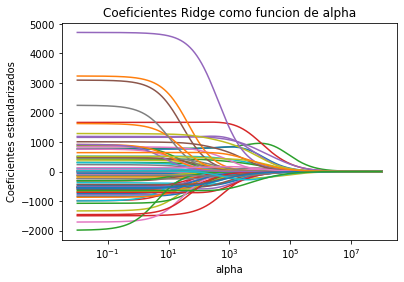

In [10]:
#Análisis previo de los alpha
alphas_ridge = np.logspace(-2, 8,400)
ridge = linear_model.Ridge(max_iter=10000)
coefs = []

for a in alphas_ridge:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas_ridge, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Ridge como funcion de alpha');

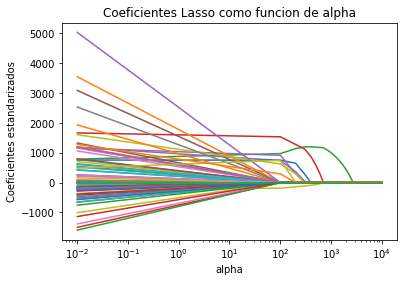

In [11]:
#Análisis previo de los alpha
alphas_lasso = np.linspace(0.01,10000,100)
lasso = linear_model.Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas_lasso:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas_lasso, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Lasso como funcion de alpha');

### GridSearch para otros algoritmos de regresión

In [12]:
#Inicializo pipelines de regresión
pipe_linr = Pipeline([('scl', None),
                    ('linr', linear_model.LinearRegression())])
pipe_ridge = Pipeline([('scl', None),
                    ('ridge', linear_model.Ridge(random_state=50))])
pipe_lasso = Pipeline([('scl', None),
                    ('lasso',linear_model.Lasso(random_state=50))])

# Parámetros para diversos pipelines
linr_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    }]

ridge_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'ridge__alpha': np.logspace(-2, 8,400)
                    }]

lasso_param_grid = [{ 
                    'scl':[StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), None],
                    'lasso__alpha': np.linspace(0.01,10000,100),
                    'lasso__max_iter': [10000],
                    }]

linr_grid_search = GridSearchCV(estimator=pipe_linr,
                        param_grid = linr_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

ridge_grid_search = GridSearchCV(estimator=pipe_ridge,
                        param_grid = ridge_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

lasso_grid_search = GridSearchCV(estimator=pipe_lasso,
                        param_grid = lasso_param_grid,
                        cv=folds,
                        verbose=1,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')


grids = [linr_grid_search, ridge_grid_search, lasso_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.6s finished
The least populated class in y has only 1 members, which is less than n_splits=5.


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


The least populated class in y has only 1 members, which is less than n_splits=5.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.0min finished


---
## Análisis

In [13]:
models = [
        {
        'name':'Linear Regression',
        'model': grids[0].best_estimator_
        },
        {
        'name':'Ridge',
        'model': grids[1].best_estimator_
        },
        {
        'name':'Lasso',
        'model': grids[2].best_estimator_
        },
        {
        'name':'XGBoost',
        'model': xgb_model
        },
        {
        'name':'LGBoost',
        'model': lgb_model
        },
        {
        'name':'CatBoost',
        'model': ctb_model
        },
        {
        'name':'Random Forest',
        'model': rndfo_model
        },
    ]

list=[]

for key in models:
    list.append(pd.DataFrame(getscores(key["model"],X_test,y_test,X_train,y_train,key["name"]),index=['MSE Test','RMSE Test','MAE Test','R2 Test','MSE Train','RMSE Train','MAE Train','R2 Train']))
    
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.concat(list,axis=1)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,Linear Regression,Ridge,Lasso,XGBoost,LGBoost,CatBoost,Random Forest
MSE Test,13754658.76245,13760056.59325,13754547.23345,8300053.51038,9255429.37747,8520474.04558,11070279.61021
RMSE Test,3708.72738,3709.45503,3708.71234,2880.98135,3042.27372,2918.98511,3327.20297
MAE Test,2437.61216,2437.45117,2437.57386,1843.33865,2002.24128,1892.09535,2184.87747
R2 Test,0.36195,0.36170,0.36196,0.61498,0.57066,0.60475,0.48647
MSE Train,13509647.18604,13513319.46413,13509652.55411,2799584.78626,5135198.07517,2841953.40645,9313390.74048
RMSE Train,3675.54720,3676.04672,3675.54793,1673.19598,2266.09754,1685.80942,3051.78485
MAE Train,2448.24824,2447.31289,2448.20210,1060.02453,1491.81252,1133.12910,2057.69365
R2 Train,0.37423,0.37406,0.37423,0.87032,0.76214,0.86836,0.56860


#### Gráficos LR

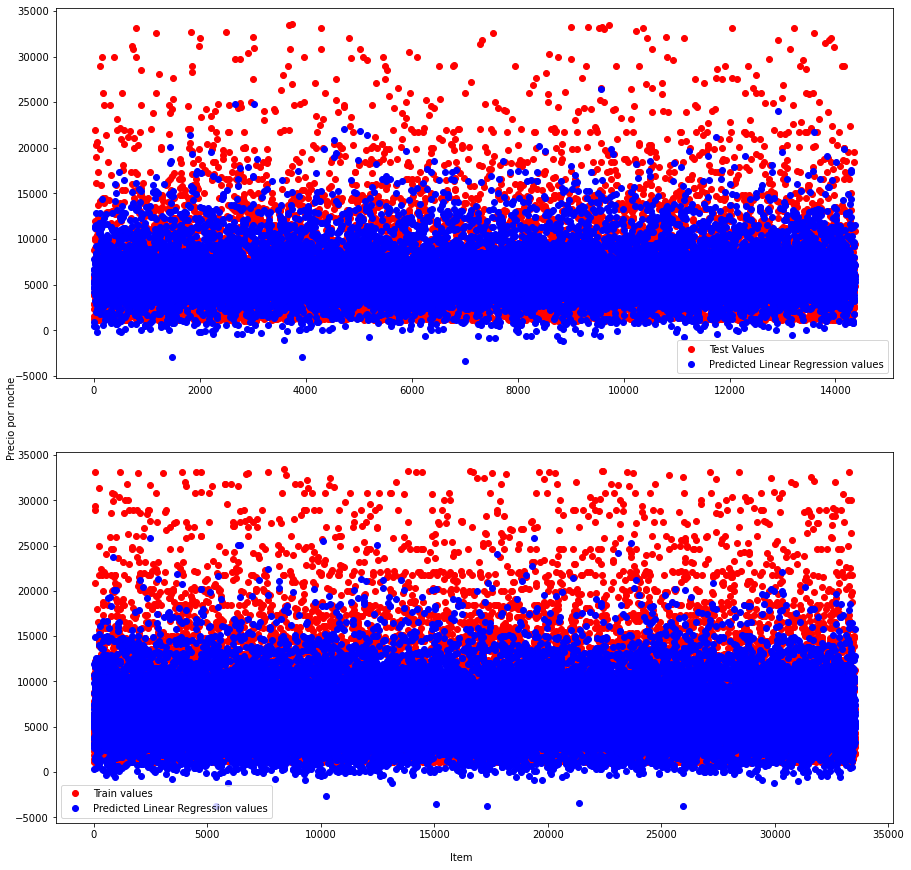

In [14]:
#Linear Regression
y_test_prediction = models[0]["model"].predict(X_test)
y_train_prediction = models[0]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[0]["name"])

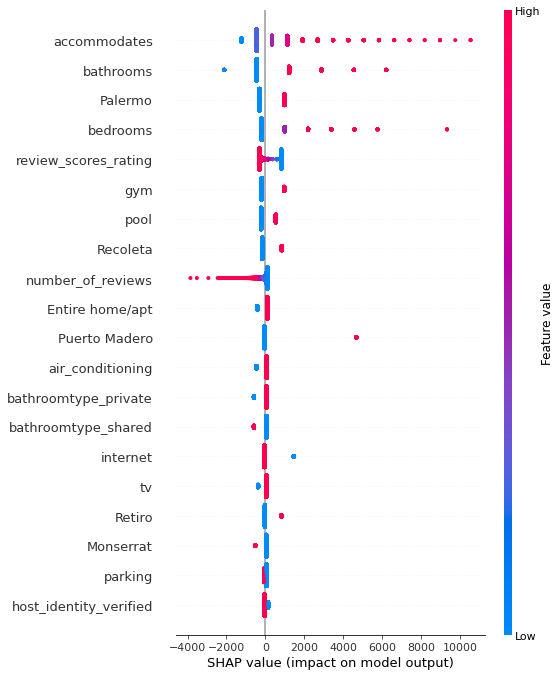

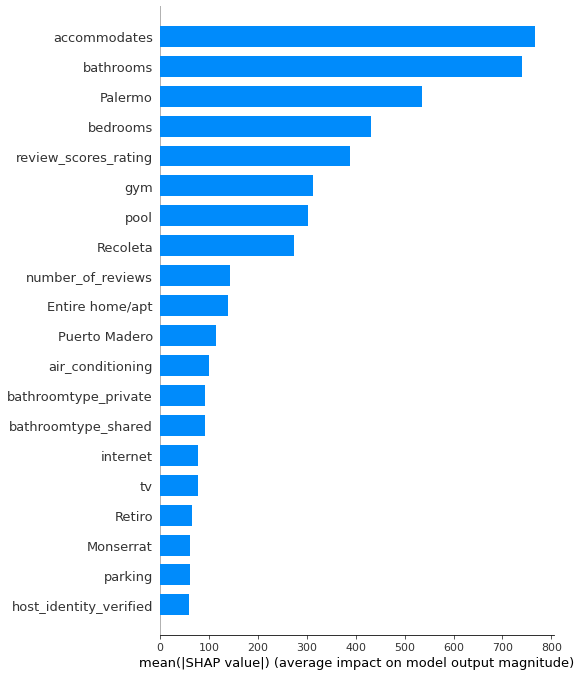

In [15]:
explainer = shap.LinearExplainer(linear_model.LinearRegression().fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Ridge

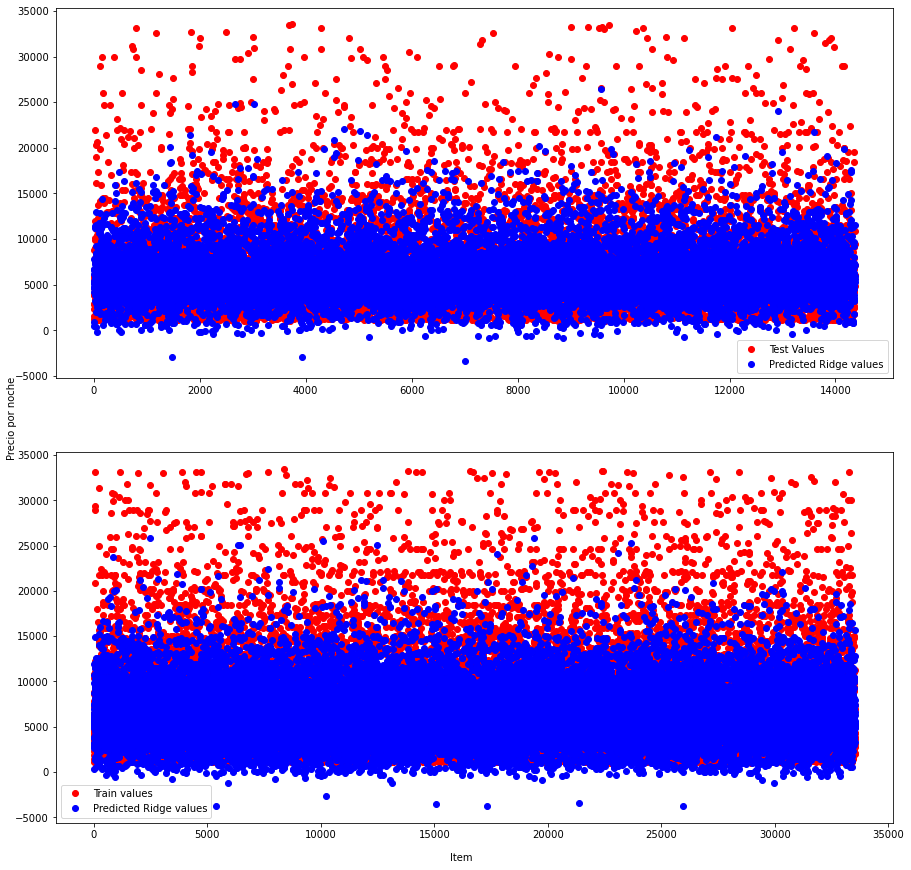

In [16]:
#Ridge
y_test_prediction = models[1]["model"].predict(X_test)
y_train_prediction = models[1]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[1]["name"])

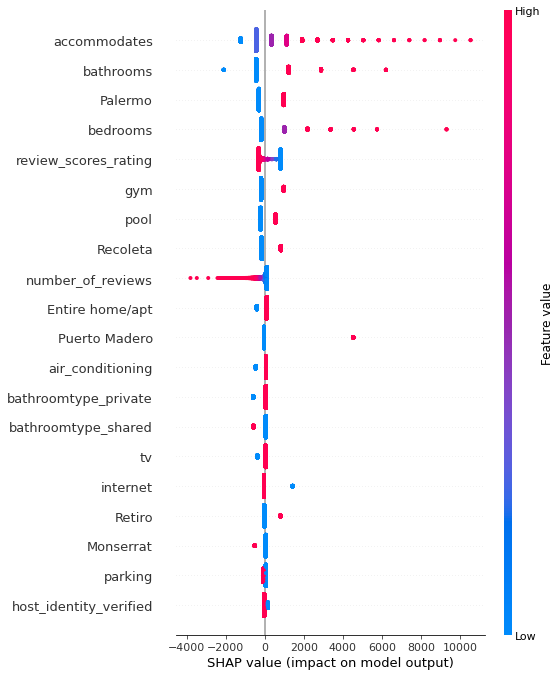

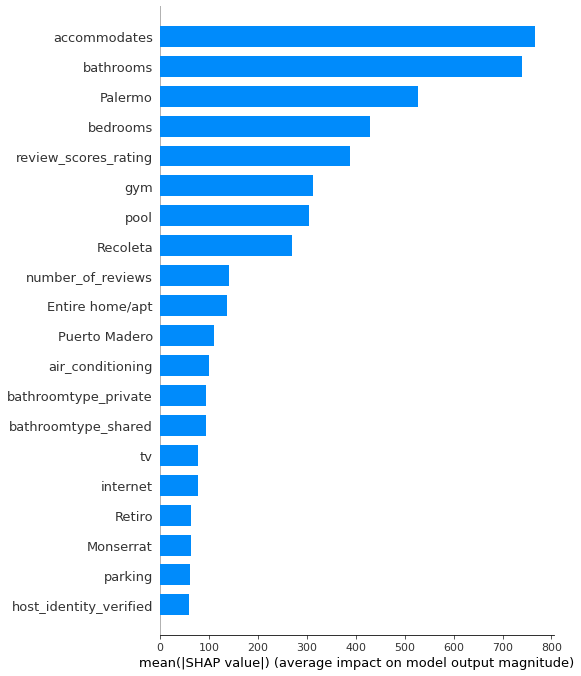

In [17]:
explainer = shap.LinearExplainer(linear_model.Ridge(alpha=models[1]["model"].steps[1][1].alpha,random_state=models[1]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Lasso

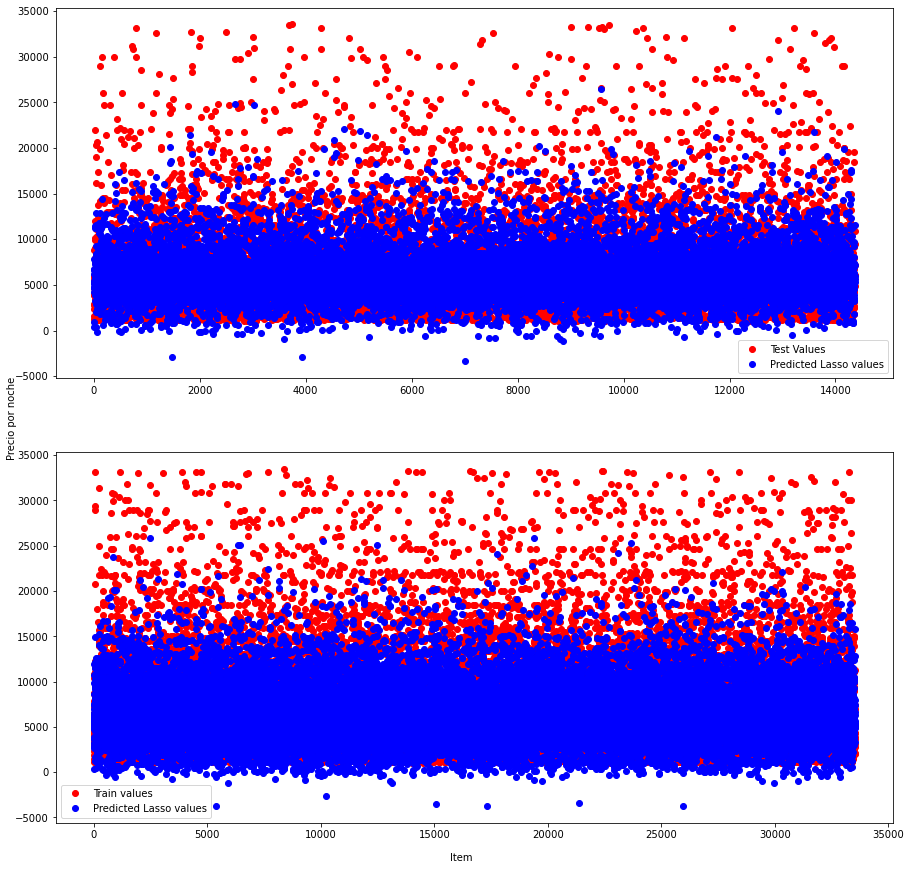

In [18]:
#Lasso
y_test_prediction = models[2]["model"].predict(X_test)
y_train_prediction = models[2]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[2]["name"])

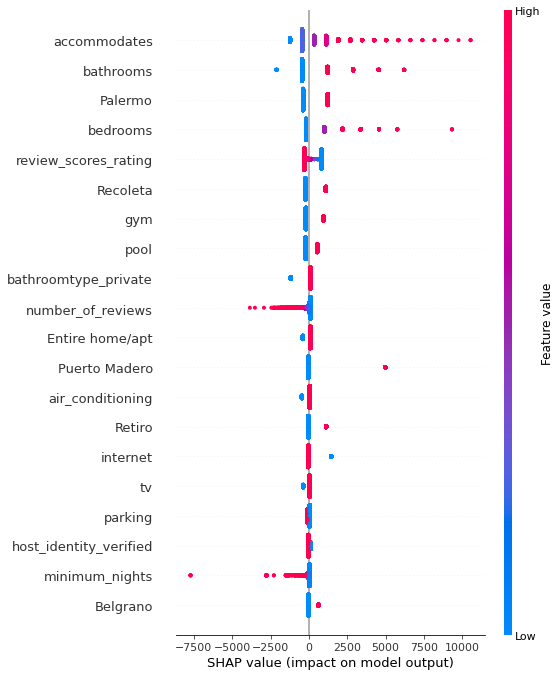

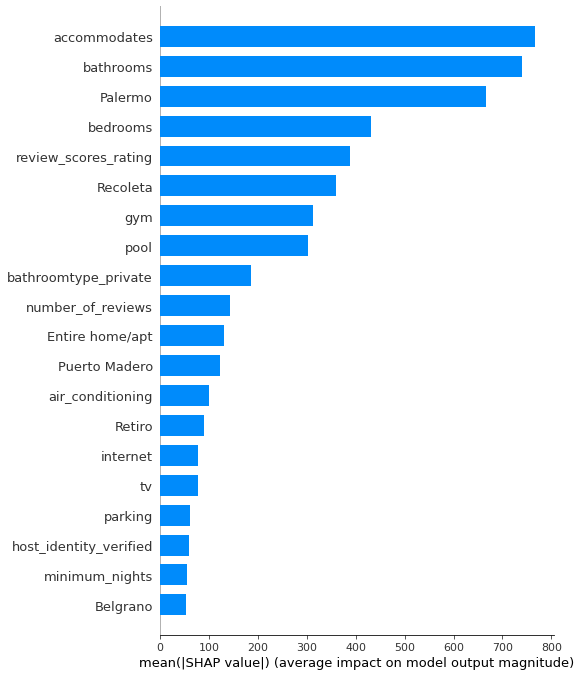

In [19]:
explainer = shap.LinearExplainer(linear_model.Lasso(alpha=models[2]["model"].steps[1][1].alpha,max_iter=models[2]["model"].steps[1][1].max_iter,random_state=models[2]["model"].steps[1][1].random_state,).fit(X_train,y_train),X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos XGBoost

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


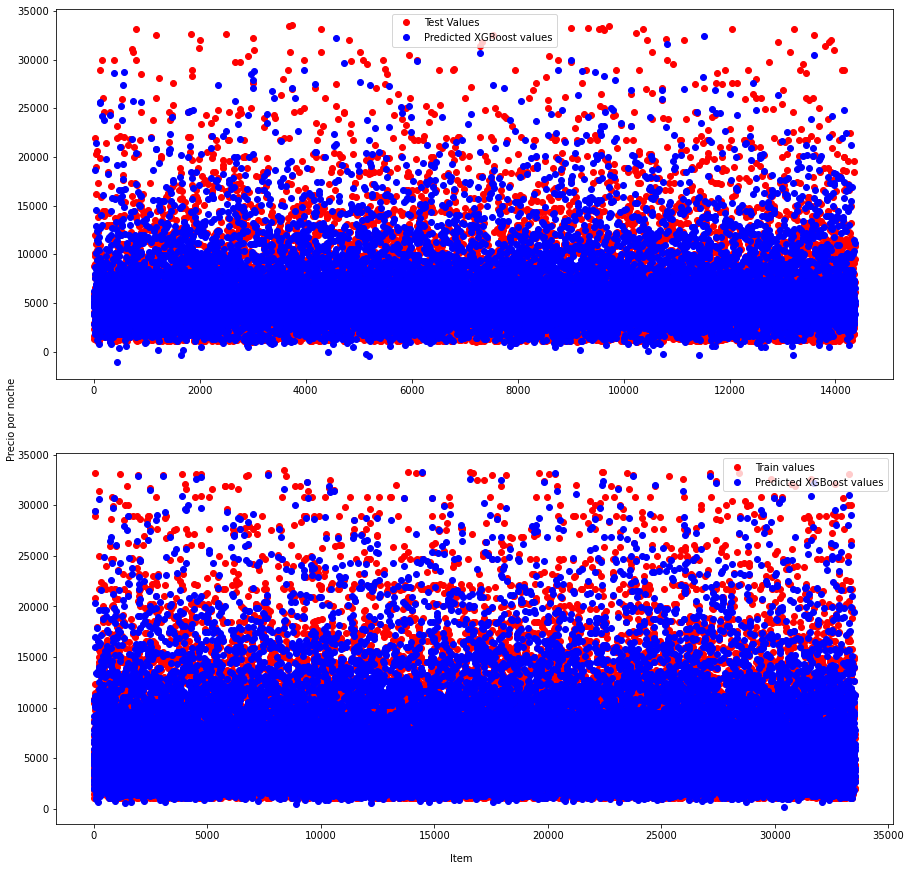

In [20]:
#XGBoost
y_test_prediction = models[3]["model"].predict(X_test)
y_train_prediction = models[3]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[3]["name"])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


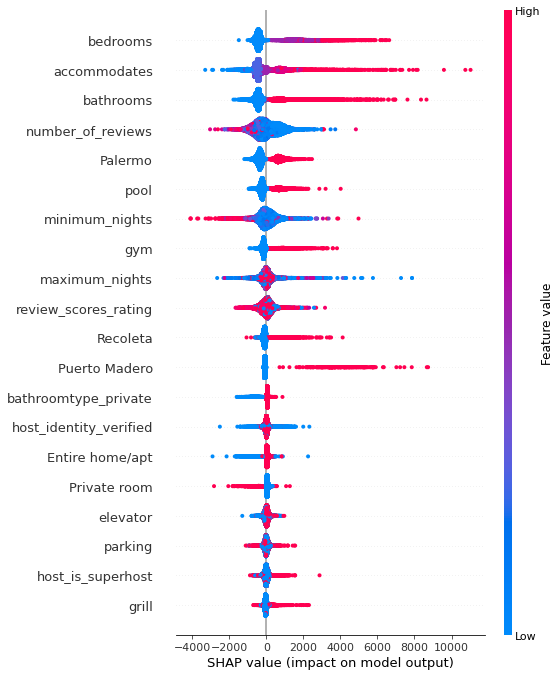

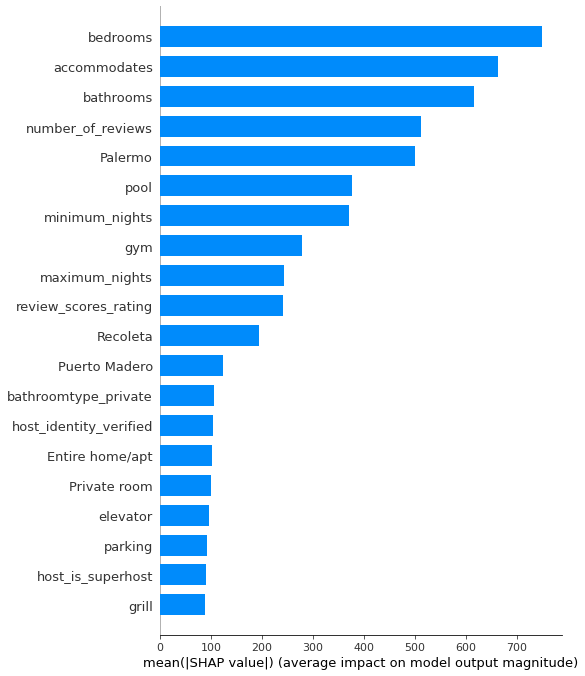

In [21]:
explainer = shap.TreeExplainer(models[3]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos LGBoost

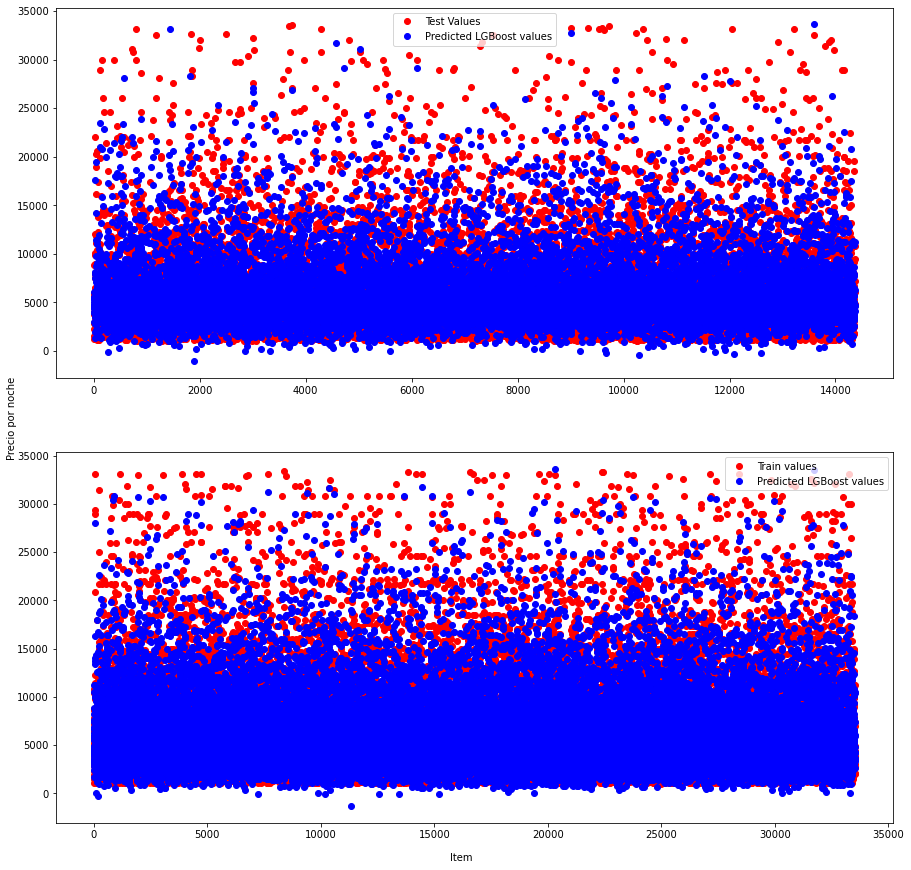

In [22]:
#LGBoost
y_test_prediction = models[4]["model"].predict(X_test)
y_train_prediction = models[4]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[4]["name"])

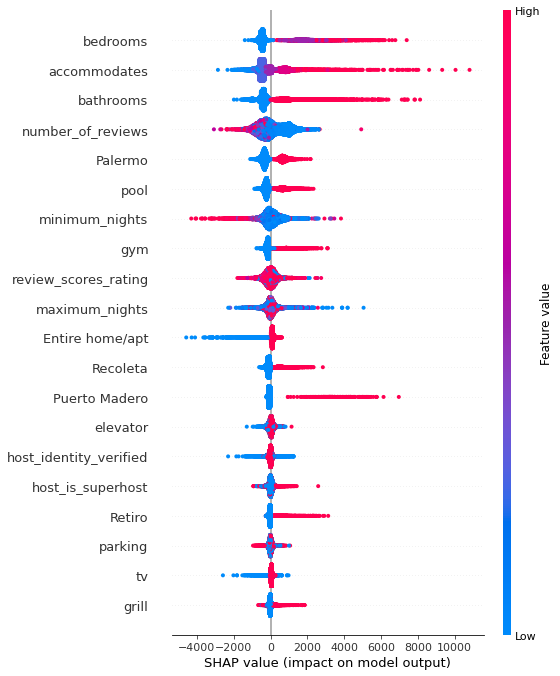

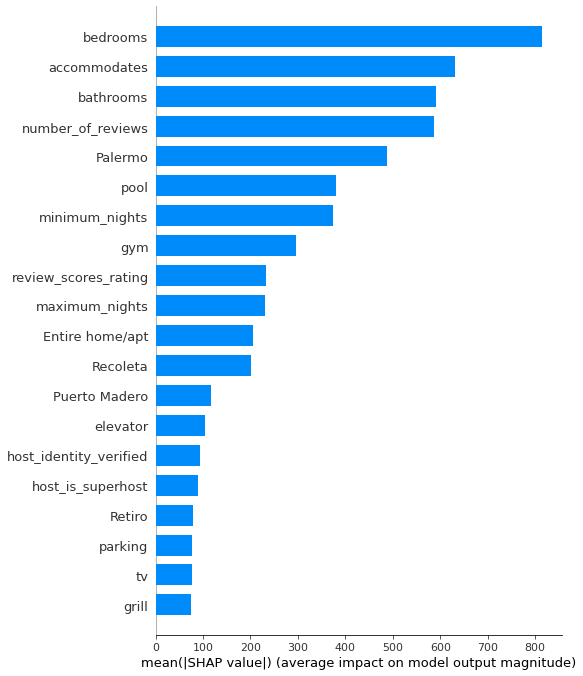

In [23]:
explainer = shap.TreeExplainer(models[4]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos CatBoost

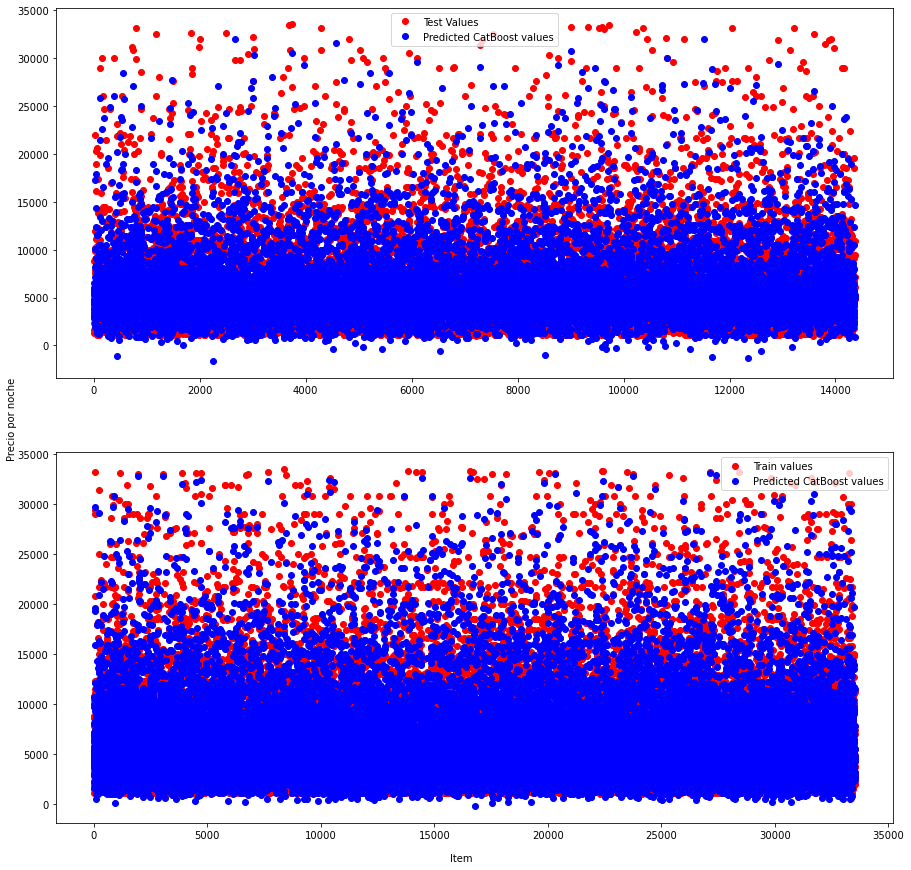

In [24]:
#LGBoost
y_test_prediction = models[5]["model"].predict(X_test)
y_train_prediction = models[5]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[5]["name"])

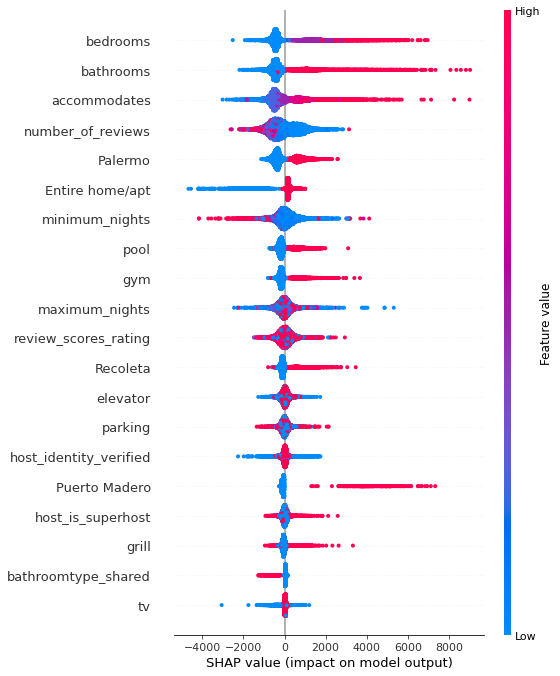

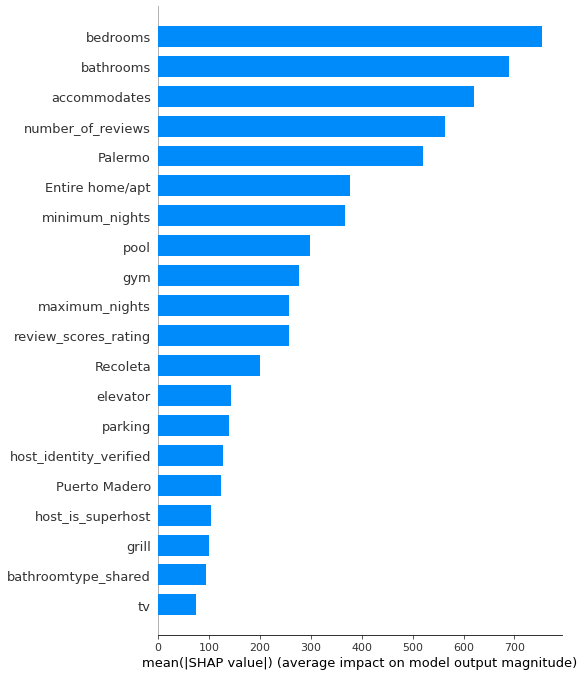

In [25]:
explainer = shap.TreeExplainer(models[5]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Gráficos Random Forest

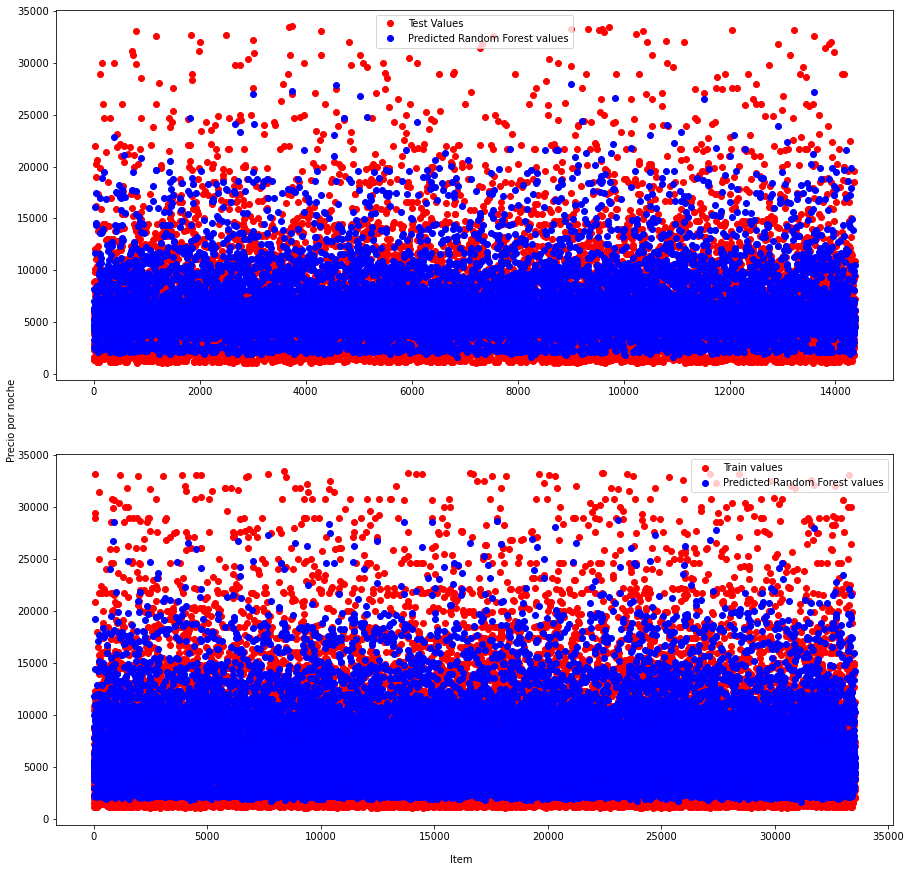

In [26]:
y_test_prediction = models[6]["model"].predict(X_test)
y_train_prediction = models[6]["model"].predict(X_train)
plot_train_test(y_test,y_test_prediction,y_train,y_train_prediction,models[6]["name"])

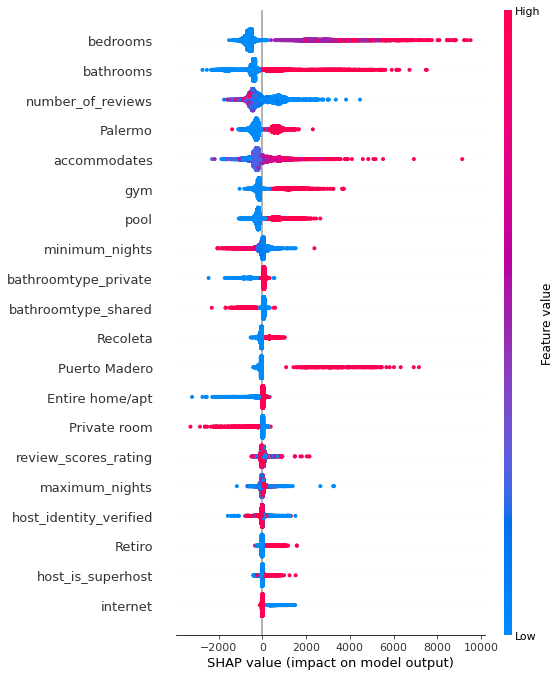

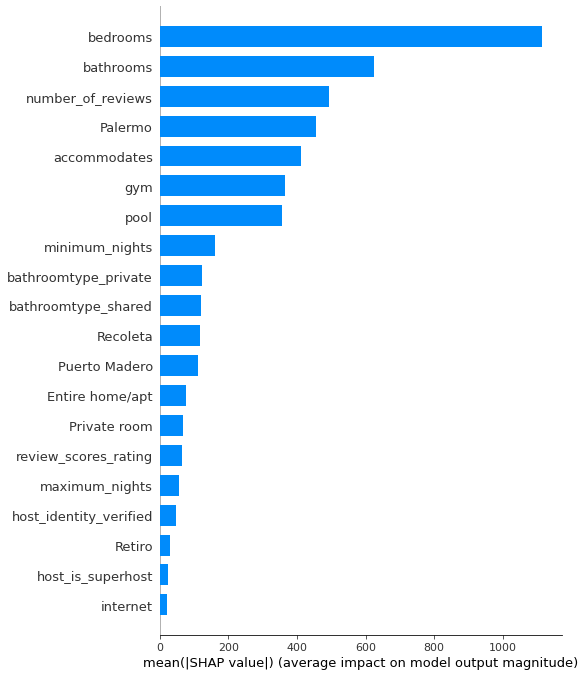

In [27]:
explainer = shap.TreeExplainer(models[6]["model"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

## Modelo

In [28]:
joblib.dump(models[3]["model"],'model2.sav')

['model2.sav']

In [29]:
models[3]["model"]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, random_state=50, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9483999666843435,
             tree_method='exact', validate_parameters=1, verbosity=None)